# Adjoint Backpropagation

Possibly the most inefficient backpropagation implementation you'll see.

The notebook implements backpropagation through the weights of a Multi Layer Perceptron following the adjoint equations. These equations are a general framework for the computation of a gradient through sequential operations.

To be efficient for large networks, adjoint backpropagation requires careful implementation and optimisation, which we did not do here as the goal is only to provide a minimal example.

## Maths

The goal of the algorithm is to compute the gradient of a scalar loss $\mathcal{L}(z_n)$ w.r.t. the parameters of a neural network $\Phi$ with $\Phi(x) = z_N = \phi_N \circ \ldots \circ \phi_1(x)$ :
</br>
</br>

$$
\frac{d\mathcal{L}}{d\theta} = \frac{\partial\mathcal{L}}{\partial \theta} + \frac{\partial\mathcal{L}}{\partial z_N}\frac{\partial z_N}{\partial\theta}.
$$
</br>
</br>

The partial $\frac{\partial z_N}{\partial\theta}$ is not trivial to compute directly as it captures the variation of the output depending on any parameters in the earlier layers of the network. To avoid its computation, a set of multipliers $\mu_i$ is introduced :
</br>
</br>

$$
\mathcal{J} = \mathcal{L} + \sum_{i=1}^N \mu_i^T (\underbrace{z_i-\phi_i(z_{i-1})}_0),\qquad (NB: \frac{d\mathcal{J}}{d\theta} = \frac{d\mathcal{L}}{d\theta}).
$$
</br>
</br>

Yielding the following gradient :
</br>
</br>

$$
\frac{d\mathcal{J}}{d\theta} = \frac{\partial \mathcal{J}}{\partial z_N}\frac{\partial z_N}{\partial \theta} + \sum_1^N \mu_i^T \frac{\partial z_i}{\partial \theta} - \sum_1^N \mu_i^T \frac{\partial \phi_i(z_{i-1})}{\partial z_{i-1}}\frac{\partial z_{i-1}}{\partial \theta} - \sum_1^N \mu_i^T \frac{\partial \phi_i(z_{i-1})}{\partial\theta} +\frac{\partial \mathcal{L}}{\partial \theta}.
$$
</br>
</br>

Taking out the $N_{th}$ term of the first sum, and observing that $\frac{\partial z_0}{\partial \theta}=0$, the conditions for $\mu$ to cancel out the expensive terms from the expression appear :
</br>
</br>

$$
    \frac{d\mathcal{J}}{d\theta} = \left(\frac{\partial \mathcal{J}}{\partial z_N} +\mu_N^T\right)\frac{\partial z_N}{\partial \theta} 
    +\sum_1^{N-1} \left( \mu_i^T - \mu_{i+1}^T \frac{\partial \phi_{i+1}(z_i)}{\partial z_i}\right)\frac{\partial z_i}{\partial \theta}
     -\sum_1^N \mu_i^T \frac{\partial \phi_i(z_{i-1})}{\partial \theta} +\frac{\partial \mathcal{L}}{\partial \theta}.
$$
</br>
</br>

The final equations to compute are the following :
</br>
</br>

$$
\mu_N = -\frac{\partial \mathcal{J}}{\partial z_N}^T, \qquad  \mu_i = \frac{\partial \phi_{i+1}(z_i)}{\partial z_i}^T \mu_{i+1},
$$
</br>
</br>

$$
\implies \frac{d\mathcal{L}}{d\theta} = -\sum_1^N  \mu_i^T \frac{\partial \phi_i(z_{i-1})}{\partial \theta} + \frac{\partial \mathcal{L}}{\partial \theta}.
$$
</br>
</br>

The partials $\frac{\partial \phi_{i+1}(z_i)}{\partial z_i},\frac{\partial \phi_i(z_{i-1})}{\partial \theta}$ are easily estimated as the layers are based on simple operations, making the algorithm tractable.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
seed = 42
np.random.seed(42)

# Activations

Basic activation functions $\sigma$ are implemented, as well as their jacobian $\frac{\partial \sigma}{\partial x}$, as they are necessary for the computations of the layer jacobians :
</br>
</br>

$$
\frac{\partial \phi}{\partial x} = \frac{\partial \sigma}{\partial z} \frac{\partial z}{\partial x},\qquad z = xW^T + B
$$
</br>
</br>

Because activations are element-wise operations, their jacobians are diagonal matrices, to save compute, we only return the diagonal.

In [2]:
class Sigmoid():
    def __call__(self,z):
        
        return 1/(1+np.exp(-z))
        
    def jac(self,z):
        a = self(z)
        prime = a*(1-a)
        return prime
    
class ReLU():
    
    def __call__(self,z):
        
        return np.maximum(0,z)
    
    def jac(self,z):
        
        temp = np.zeros(z.shape)
        temp[z>0.] = 1
        return temp
        
class Identity():
    
    def __call__(self,z):
        return z
    
    def jac(self,z):
        return np.ones(z.shape)
    

## The Fully Connected Layer

Implements the fully connected layer $\phi_i = \sigma(x W_i^T + B_i)$ and it's backward step, which computes the partials $\frac{\partial \phi_i}{\partial x}, \frac{\partial \phi_i}{\partial \theta}$ and returns the next adjoint step $\mu_{i-1}$.

Inputs $x$ are remembered during the forward pass as they are necessary for the backpropagation. The gradients are computed as :

$$
\frac{\partial \phi}{\partial x} = \frac{\partial \sigma}{\partial z} \frac{\partial z}{\partial x},\qquad\frac{\partial \phi}{\partial \theta} = \frac{\partial \sigma}{\partial z} \frac{\partial z}{\partial \theta}
$$

In [3]:
class Linear():

    def __init__(self,d_in,d_out,act = Sigmoid(),init=1, beta = 0.9):
        self.d_in, self.d_out = d_in, d_out
        self.w = init * np.random.randn(d_in*d_out).reshape(d_in,d_out)
        self.b = init * np.random.randn(1,d_out)
        self.act = act
        
        self.beta = beta
        self.ema_w = 0.
        self.ema_b = 0.
        
    def __call__(self,x):
        self.x = x # Remember input for backprop
        z = x.dot(self.w)+self.b
        a = self.act(z)
        return a

    def adjoint_step(self,z,mu):
        
        # Gradient wrt x
        da_dz = self.act.jac(z)
        grad = [da.reshape(-1,1)*self.w.T for da in da_dz]
        vjp_x = np.einsum('bi,bij->bj',mu,np.stack(grad))
        
        # Gradient wrt W
        grad_w = [da.reshape(-1,1)*x_i for (da,x_i) in zip(da_dz,self.x)]
        dl_dw = np.stack(
            [(mu_i.reshape(-1,1)*grad_i).reshape(-1) for (mu_i,grad_i) in zip(mu,grad_w)]).mean(0)
        self.dl_dw = -dl_dw.reshape(self.d_out,self.d_in).T
        
        # Gradient wrt B
        dl_db = np.stack([mu_i*da_i for (mu_i,da_i) in zip(mu,da_dz)]).mean(0)
        self.dl_db = -dl_db.reshape(1,-1)
        
        return vjp_x 
    
    def gradient_step(self,lr,wd=0.):
        # Simple momentum scheme with potential weight decay
        self.ema_w = self.beta * self.ema_w + (1-self.beta) * (self.dl_dw + wd * self.w)
        self.ema_b = self.beta * self.ema_b + (1-self.beta) * (self.dl_db + wd * self.b)
        
        self.w = self.w - lr * self.ema_w
        self.b = self.b - lr * self.ema_b

# Multi Layer Perceptron

Implements the actual neural network by chaining the layers and computing the forward and backward pass

In [4]:
class MLP():
    
    def __init__(self,sizes,act=Sigmoid(),init=1.):
        
        assert len(sizes)>2, "Assumes at least one hidden layer"
        n_layers = len(sizes)-1
        self.layers = [Linear(sizes[i],sizes[i+1],act=act) 
                          for i in range(n_layers-1)]
        self.layers.append(Linear(sizes[-2],sizes[-1],act=Identity(),init=init))
        
    def __call__(self,x):
        
        for l in self.layers:
            x = l(x)
        return x
    
    def backpropagate(self,z,mu):
        
        for l in self.layers[::-1]:
            mu = l.adjoint_step(z,mu)
            z = l.x
    
    def gradient_step(self,lr,wd=0.):
        
        for l in self.layers:
            l.gradient_step(lr,wd)


# MSELoss

Simple regression loss, the loss and it's gradient wrt the input $z$ are computed concurrently

$$
\mathcal{L} = \frac{1}{2*n_x} \sum_{k=1}^{n_x} \Vert z_k - y_k \Vert^2_2
$$

$$
\mu_{N,k} = -\frac{\partial \mathcal{L}}{\partial z_k} =  y_k - z_k
$$



In [5]:
class MSELoss():
    def __call__(self,x,y):
        loss = 0.5*np.mean(np.sum((x-y)**2,1))
        adjoint_state = -(1/x.shape[0]) * (x-y)
        return loss, adjoint_state
    

## Linear Regression with Sigmoid

In [6]:
x = np.random.uniform(0.,1.,size=100).reshape(-1,1)
y = 10*x +3
sizes = [1,64,128,64,1]
lossfunc = MSELoss()
network = MLP(sizes,act=Sigmoid())
lr = 1e-1
wd = 1e-4
losses = []
batch_size = 50

In [7]:
pbar = tqdm(range(500))
for i in pbar:
    for j in range(int(x.shape[0]/batch_size)):
        x_j, y_j = x[j*batch_size:(j+1)*batch_size], y[j*batch_size:(j+1)*batch_size]
        out = network(x_j)
        loss, adjoint_state = lossfunc(out,y_j)
        network.backpropagate(out,adjoint_state)
        network.gradient_step(lr,wd)
        losses.append(loss)
    pbar.set_description('Loss : {:.3e}'.format(loss))

Loss : 5.304e-03: 100%|██████████| 500/500 [00:21<00:00, 23.22it/s]


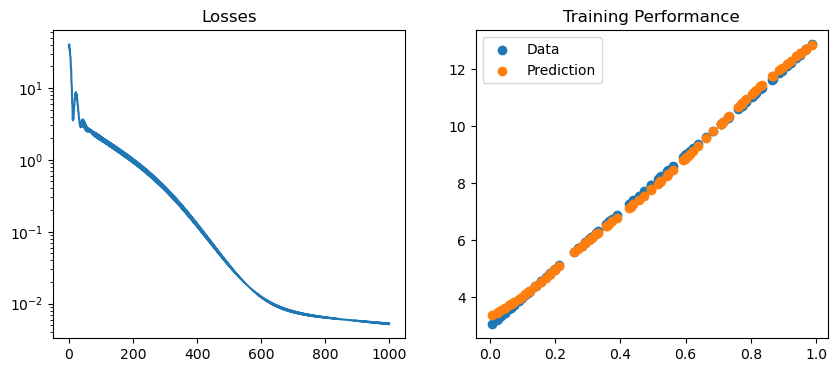

In [8]:
out = network(x)
fig, axs= plt.subplots(ncols=2,figsize=(10,4))
plt.sca(axs[0])
plt.semilogy(losses)
plt.title('Losses')
plt.sca(axs[1])
plt.title('Training Performance')

plt.scatter(x,y,label='Data')
plt.scatter(x,out,label='Prediction')
plt.legend()


## Linear Regression with ReLU

In [9]:
x = np.random.uniform(0.,1.,size=100).reshape(-1,1)
y = 10*x +3
sizes = [1,64,128,64,1]
lossfunc = MSELoss()
network = MLP(sizes,act=ReLU(),init=1e-4)
lr = 1e-2
wd = 1e-3
losses = []
batch_size = 50

In [10]:
pbar = tqdm(range(500))
for i in pbar:
    for j in range(int(x.shape[0]/batch_size)):
        x_j, y_j = x[j*batch_size:(j+1)*batch_size], y[j*batch_size:(j+1)*batch_size]
        out = network(x_j)
        loss, adjoint_state = lossfunc(out,y_j)
        network.backpropagate(out,adjoint_state)
        network.gradient_step(lr,wd)
        losses.append(loss)
    pbar.set_description('Loss : {:.3e}'.format(loss))

Loss : 2.139e-04: 100%|██████████| 500/500 [00:23<00:00, 21.47it/s]


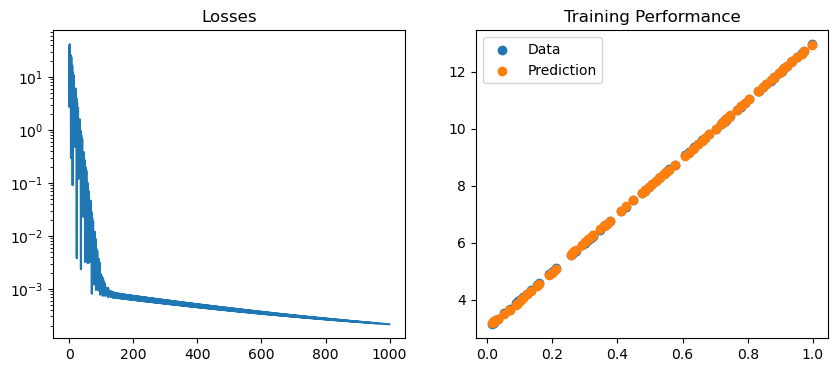

In [11]:
out = network(x)
fig, axs= plt.subplots(ncols=2,figsize=(10,4))
plt.sca(axs[0])
plt.semilogy(losses)
plt.title('Losses')
plt.sca(axs[1])
plt.title('Training Performance')

plt.scatter(x,y,label='Data')
plt.scatter(x,out,label='Prediction')
plt.legend()


## Non Linear case

In [12]:
x = np.random.uniform(0.,1.,size=100).reshape(-1,1)
y = 10*(-x**2+x)
sizes = [1,64,64,1]
lossfunc = MSELoss()
network = MLP(sizes,act=ReLU(),init=1)
lr = 1e-1
wd = 1e-4
losses = []
batch_size = 50

In [13]:
pbar = tqdm(range(1000))
for i in pbar:
    for j in range(int(x.shape[0]/batch_size)):
        x_j, y_j = x[j*batch_size:(j+1)*batch_size], y[j*batch_size:(j+1)*batch_size]
        out = network(x_j)
        loss, adjoint_state = lossfunc(out,y_j)
        network.backpropagate(out,adjoint_state)
        network.gradient_step(lr,wd)
        losses.append(loss)
    pbar.set_description('Loss : {:.3e}'.format(loss))

Loss : 1.010e-03: 100%|██████████| 1000/1000 [00:14<00:00, 70.71it/s]


Text(0.5, 0.98, 'Almost as good as linear regression :D')

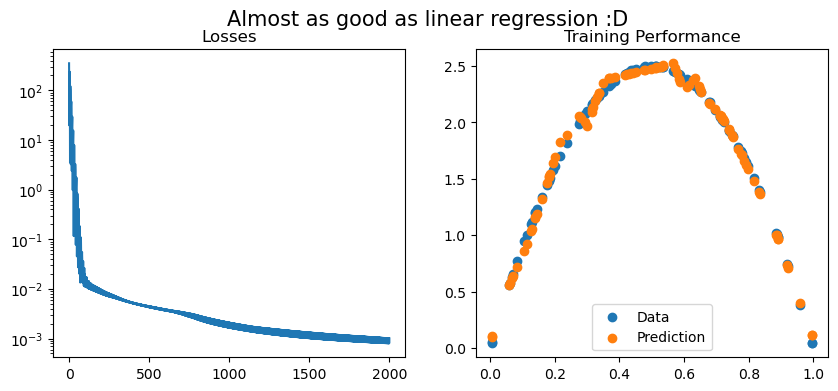

In [14]:
out = network(x)
fig, axs= plt.subplots(ncols=2,figsize=(10,4))
plt.sca(axs[0])
plt.semilogy(losses)
plt.title('Losses')
plt.sca(axs[1])
plt.title('Training Performance')

plt.scatter(x,y,label='Data')
plt.scatter(x,out,label='Prediction')
plt.legend()
fig.suptitle('Almost as good as linear regression :D',fontsize=15)

# 2D Wave

In [15]:
dx = 100
x = np.meshgrid(np.linspace(0,2*np.pi,dx),np.linspace(0,2*np.pi,dx))
x = np.concatenate([x_i.reshape(1,-1) for x_i in x]).T
radius = np.sqrt((x[:,0]-np.pi)**2+(x[:,1]-np.pi)**2)
y = 10*(-radius**2+radius).reshape(-1,1)

sizes = [x.shape[-1],64,64,y.shape[-1]]
lossfunc = MSELoss()
network = MLP(sizes,act=ReLU(),init=1e-6)
lr = 1e-2
wd = 1e-4
losses = []
batch_size = 50
subiters = int(x.shape[0]/batch_size)

In [16]:
pbar = tqdm(range(100))
for i in pbar:
    for j in range(subiters):
        idx = np.random.choice(x.shape[0],size=batch_size,replace=False)
        x_j, y_j = x[idx], y[idx]
        out = network(x_j)
        loss, adjoint_state = lossfunc(out,y_j)
        network.backpropagate(out,adjoint_state)
        network.gradient_step(lr,wd)
        losses.append(loss)
    pbar.set_description('Loss : {:.3e}'.format(np.mean(losses[-subiters:])))

Loss : 2.834e-01: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


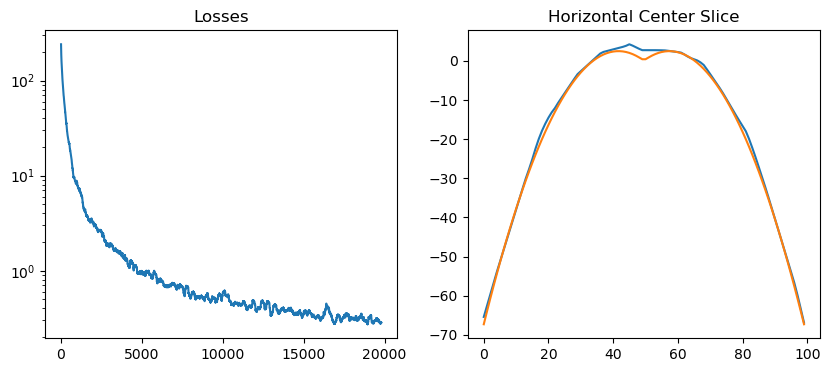

In [17]:
out = network(x).reshape(dx,dx)
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10,4))
plt.sca(ax1)
plt.title('Losses')
plt.semilogy(np.convolve(losses,(1/subiters)*np.ones(subiters),mode='valid'))
plt.sca(ax2)
plt.title('Horizontal Center Slice')
plt.plot(out[int(dx/2)])
plt.plot(y.reshape(dx,dx)[int(dx/2)])

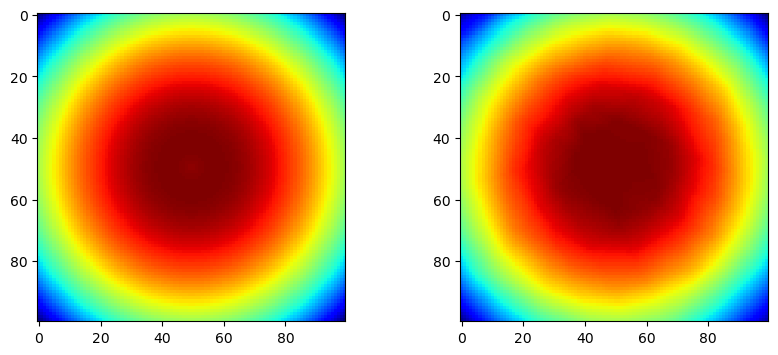

In [18]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(10,4))
plt.sca(ax1)
plt.imshow(y.reshape(dx,dx),cmap=plt.cm.jet)
plt.sca(ax2)
plt.imshow(out,vmin=y.min(),vmax=y.max(),cmap=plt.cm.jet)

## Creating Readme

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [23]:
os.system('rm backpropagation_numpy_files/*')
os.system('jupyter nbconvert --to markdown backpropagation_numpy.ipynb')
os.system('mv backpropagation_numpy.md README.md')
os.system('git add backpropagation_numpy_files/')


[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook backpropagation_numpy.ipynb to markdown
[NbConvertApp] Support files will be in backpropagation_numpy_files/
[NbConvertApp] Making directory backpropagation_numpy_files
[NbConvertApp] Making directory backpropagation_numpy_files
[NbConvertApp] Making directory backpropagation_numpy_files
[NbConvertApp] Making directory backpropagation_numpy_files
[NbConvertApp] Making directory backpropagation_numpy_files
[NbConvertApp] Writing 14127 bytes to backpropagation_numpy.md


0